# o'reillyのネゴザメ言語モデルの本
再帰型ニューラルネットワーク（RNN）

## [目次](TableOfContents.ipynb)
- [環境準備](#環境準備)
  - [インストール](#インストール)
  - [インポート](#インポート)
- [再帰型ニューラルネットワーク（RNN）](#再帰型ニューラルネットワーク（RNN）)
  - [先ずは、RNNレイヤの実装](#先ずは、RNNレイヤの実装)
  - [T個の時系列データの処理を行うTime RNN実装](#T個の時系列データの処理を行うTime_RNN実装)
  - [RNNを使用した言語モデルのSimpleRnnlm実装](#RNNを使用した言語モデルのSimpleRnnlm実装)

## 参考
- https://github.com/oreilly-japan/deep-learning-from-scratch-2/tree/master/ch05
- [再帰型ニューラルネットワーク（RNN） - 開発基盤部会 Wiki](https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?%E5%86%8D%E5%B8%B0%E5%9E%8B%E3%83%8B%E3%83%A5%E3%83%BC%E3%83%A9%E3%83%AB%E3%83%8D%E3%83%83%E3%83%88%E3%83%AF%E3%83%BC%E3%82%AF%EF%BC%88RNN%EF%BC%89)

## 環境準備

### インストール

In [ ]:
!pip install numpy
!pip install matplotlib

### インポート

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定

## 再帰型ニューラルネットワーク（RNN）

### 先ずは、RNNレイヤの実装

#### 定義

In [ ]:
# RNNレイヤの実装
class _RNN:
    # 初期化メソッドの定義
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b] # パラメタ
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)] # 勾配
        self.cache = None # 変数の保存用
    
    # 順伝播メソッドの定義
    def forward(self, x, h_prev):
        # パラメタを取得
        Wx, Wh, b = self.params
        
        # 順伝播を計算:式(5.10)
        t = np.dot(h_prev, Wh) + np.dot(x, Wx) + b # 重み付き和
        h_next = np.tanh(t) # 活性化
        
        # 逆伝播に用いる変数を保存
        self.cache = (x, h_prev, h_next)
        
        return h_next
    
    # 逆伝播メソッドの定義
    def backward(self, dh_next):
        # 変数を取得
        Wx, Wh, b = self.params # パラメタ
        x, h_prev, h_next = self.cache # データ
        
        # 勾配を計算
        dt = dh_next * (1 - h_next ** 2)
        db = np.sum(dt, axis=0)
        dWh = np.dot(h_prev.T, dt)
        dh_prev = np.dot(dt, Wh.T)
        dWx = np.dot(x.T, dt)
        dx = np.dot(dt, Wx.T)
        
        # 結果を格納
        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db
        # 同じ大きさの ndarray を用意して[...]で深いコピー
        
        return dx, dh_prev

#### 実行

##### データの準備

In [ ]:
# バッチサイズ
batch_size = 100

# Embedベクトルの次元を指定
wordvec_size = 10
# 隠れ状態ベクトルの次元を指定
hidden_size = 5

# 入力データに対応する重みを生成
Wx = np.random.randn(wordvec_size, hidden_size)
print('Wx:', Wx.shape)
# 1つ前の出力に対応する重みを生成
Wh = np.random.randn(hidden_size, hidden_size)
print('Wh:', Wh.shape)
# バイアスを生成
b = np.zeros(hidden_size)
print('b:', b.shape)

# 順伝播の入力を生成
x1 = np.arange(batch_size * wordvec_size).reshape((batch_size, wordvec_size))
h0 = np.zeros((batch_size, hidden_size)) # np.tanh(np.dot(x1, Wx) + b)

# 受け皿を初期化
h1 = np.empty((batch_size, hidden_size)) # np.tanh(np.dot(h0, Wh) + np.dot(x1, Wx) + b)

# 逆伝播の入力を生成
dh1 = np.random.randn(batch_size, hidden_size)

##### 順伝播と逆伝播

In [ ]:
# インスタンスを作成
layer = _RNN(Wx, Wh, b)

# 順伝播の計算
h1 = layer.forward(x1, h0)
print('h0:', h0.shape)
print('x1:', x1.shape)
print('h1:', h1.shape)
print('-'*50)

# 逆伝播の計算
dx1, dh0 = layer.backward(dh1)
print('dh0:', dh0.shape)
print('dx1:', dx1.shape)
print('dh1:', dh1.shape)
print('-'*50)

# 勾配の表示
for name, grad in zip(['dWx', 'dWh', 'db'], layer.grads):
    print(name, grad.shape)

### T個の時系列データの処理を行うTime_RNNの実装

#### 定義

In [ ]:
# Time RNNレイヤの実装
class _TimeRNN:
    # 初期化メソッドの定義
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b] # パラメタ
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)] # 勾配
        self.layers = None # レイヤ
        self.h, self.dh = None, None # 中間オブジェクト
        self.stateful = stateful # フラグ
    
    # ネットワークの継続メソッド？
    def set_state(self, h):
        self.h = h
    
    # ネットワークの切断メソッド
    def reset_state(self):
        self.h = None
    
    # 順伝播メソッドの定義
    def forward(self, xs):
        # パラメタを取得
        Wx, Wh, b = self.params
        
        # データに関する値を取得
        N, T, D = xs.shape # バッチ、時間サイズ、ｘの次元
        D, H = Wx.shape # ｘの次元、ｈの次元
        
        # オブジェクトを初期化
        self.layers = []
        hs = np.empty((N, T, H), dtype='f')
        
        # ネットワークを切断
        if not self.stateful or self.h is None:
            # hを初期化
            self.h = np.zeros((N, H), dtype='f')
        
        # 1ブロックの処理
        for t in range(T):
            # t番目のRNNレイヤを作成
            layer = _RNN(*self.params)
            
            # 順伝播の計算
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h # 値を格納
            
            # レイヤを格納
            self.layers.append(layer)
        
        return hs
    
    # 逆伝播メソッドの定義
    def backward(self, dhs):
        # パラメタを取得
        Wx, Wh, b = self.params
        
        # データに関する値を取得
        N, T, H = dhs.shape
        D, H = Wx.shape
        
        # オブジェクトを初期化
        dxs = np.empty((N, T, D), dtype='f')
        dh = 0
        grads = [0, 0, 0]
        
        # 1ブロックの処理
        for t in reversed(range(T)):
            # t番目のRNNレイヤを取得
            layer = self.layers[t]
            
            # 逆伝播の計算
            # 出力ベクトルと隠れ状態ベクトルに分岐
            # していたので其々の逆伝播の値と足す
            dx, dh = layer.backward(dhs[:, t, :] + dh)
            dxs[:, t, :] = dx # 値を格納
            
            # 各パラメタの勾配を加算
            for i, grad in enumerate(layer.grads):
                grads[i] += grad # 各パラメタの各時間での勾配を加算していくらしい。
        
        # 各パラメタの勾配を格納
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
            # 同じ大きさの ndarray を用意して[...]で深いコピー
        self.dh = dh
        
        return dxs

#### 実行

##### データの準備

In [ ]:
# バッチサイズ
batch_size = 100
# 時間サイズ
time_size = 10

# Embedベクトルの次元を指定
wordvec_size = 10
# 隠れ状態ベクトルの次元を指定
hidden_size = 5

# 入力データに対応する重みを生成
Wx = np.random.randn(wordvec_size, hidden_size)
print('Wx:', Wx.shape)
# 1つ前の出力に対応する重みを生成
Wh = np.random.randn(hidden_size, hidden_size)
print('Wh:', Wh.shape)
# バイアスを生成
b = np.zeros(hidden_size)
print('b:', b.shape)

# 順伝播の入力を生成
xs = np.arange(batch_size * time_size * wordvec_size).reshape((batch_size, time_size, wordvec_size))

# 受け皿を初期化
hs = np.empty((batch_size, time_size, hidden_size))

# 逆伝播の入力を生成
dhs = np.arange(batch_size * time_size * hidden_size).reshape((batch_size, time_size, hidden_size))

##### 順伝播と逆伝播

In [ ]:
# インスタンスを作成
layer = _TimeRNN(Wx, Wh, b)

# 順伝播の計算
hs = layer.forward(xs)
print('xs:', xs.shape)
print('hs:', hs.shape)
print('-'*50)

# 逆伝播の計算
dsx = layer.backward(dhs)
print('dhs:', dhs.shape)
print('dsx:', dsx.shape)
print('-'*50)

# 重み（の次元
for name, grad in zip(['dWx', 'dWh', 'db'], layer.grads):
    print(name, grad.shape)

### RNNを使用した言語モデル、SimpleRnnlmの実装
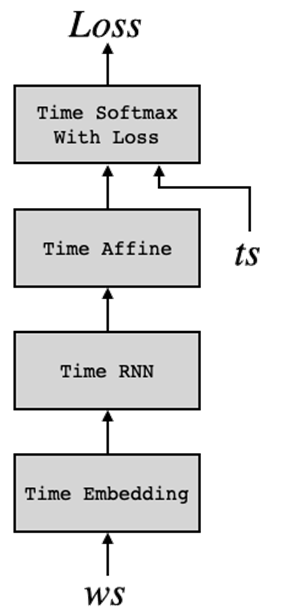

#### 定義
TimeRNNに続き、T個の時系列データの処理を行う  
TimeEmbedding、TimeAffine、TimeSoftmaxWithLossなどの定義も行う。
- TimeEmbedding  
T個の時系列データのEmbedding処理を行う。
- TimeAffine  
T個の時系列データのAffine変換処理を行う。
- TimeSoftmaxWithLoss  
  - T個の時系列データのSoftmaxWithLoss処理を行う。
  - 損失の計算は、T個の平均を取る（L = (L1+L2+L3+...+Lt-1)/T）。

In [ ]:
from nekozame.common.time_layers import *

class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 重みの初期化
        #（Xavierの初期化、KasagoDL4.ipynb）
        
        # embed
        embed_W = (rn(V, D) / 100).astype('f')
        
        # rnn
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        
        # affine
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # レイヤの生成
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]

        # すべての重みと勾配をリストにまとめる
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.rnn_layer.reset_state()

#### 実行

##### データの準備

In [ ]:
from nekozame.dataset import ptb

# コーパスのサイズ
corpus_size = 1000

# 学習データの読み込み
# 929589語から成る文
corpus, word_to_id, id_to_word = ptb.load_data('train')

# コーパスの長さを短く
corpus = corpus[:corpus_size]

# コーパスの単語数
vocab_size = int(max(corpus) + 1)

# 時系列予測（次単語予測）の
xs = corpus[:-1]  # 教師データ
ts = corpus[1:]   # 教師ラベル

print('corpus size: %d, vocabulary size: %d' % (corpus_size, vocab_size))

##### 学習と評価

In [ ]:
# ハイパーパラメタの設定

# バッチサイズ
batch_size = 10
# 時間サイズ
time_size = 5

# Embedベクトルの次元を指定
wordvec_size = 100
# 隠れ状態ベクトルの次元を指定
hidden_size = 100

# 学習率
lr = 0.1
# エポック
max_epoch = 100

###### train_custom_loop

In [ ]:
from nekozame.common.optimizer import SGD

# 学習時に使用する変数
data_size = len(xs) # corpus_size - 1 = 999
max_iters = data_size // (batch_size * time_size) # = 999/(10*5) = 19
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

# モデルの生成
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

# ミニバッチの各サンプルの読み込み開始位置を計算
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        
        # イテレーション毎の学習
        
        # ミニバッチの取得
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1

        # 所得したミニバッチで
        
        # 勾配を求め、
        loss = model.forward(batch_x, batch_t)
        model.backward()
        
        # パラメタ更新
        optimizer.update(model.params, model.grads)
        
        # 誤差の情報
        total_loss += loss
        loss_count += 1

    # エポック毎にパープレキシティの評価
    ppl = np.exp(total_loss / loss_count)
    print('| epoch %d | perplexity %.2f' % (epoch+1, ppl))
    ppl_list.append(float(ppl)) # グラフ描画用
    
    # 誤差の初期化
    total_loss, loss_count = 0, 0

# グラフの描画
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()

###### train
上記のコードをRnnlmTrainerに置き換えたバージョン

In [ ]:
from nekozame.common.optimizer import SGD
from nekozame.common.trainer import RnnlmTrainer

# モデルの生成
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
trainer = RnnlmTrainer(model, SGD(lr))

trainer.fit(xs, ts, max_epoch, batch_size, time_size)
trainer.plot()